In [497]:
from google.colab import drive
drive.mount('/content/gdrive')
dataset_path = "gdrive/My Drive/Colab Notebooks/DEEP LEARNING/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from scipy.io import loadmat
import pandas as pd
from matplotlib import pyplot
mat = loadmat(dataset_path + 'Xtrain.mat')

In [499]:
mdata = mat['Xtrain']
series = pd.DataFrame(mdata, columns={"t"})
series

,t
0,86
1,141
2,95
3,41
4,22
...,...
995,61
996,20
997,12
998,13


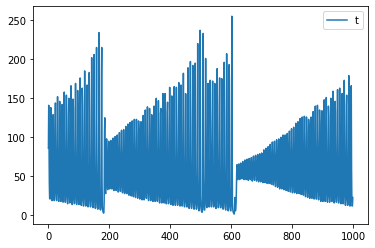

In [336]:
series.plot()

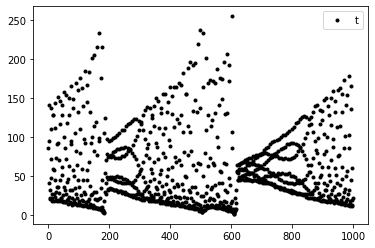

In [337]:
series.plot(style='k.')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd56e733240>]],
      dtype=object)

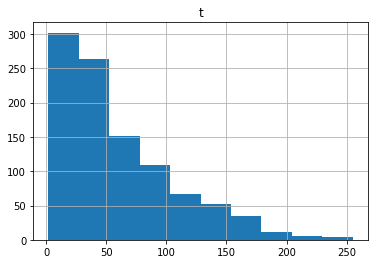

In [338]:
series.hist()

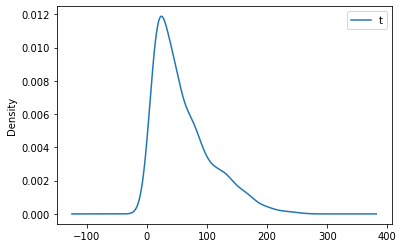

In [339]:
series.plot(kind='kde')

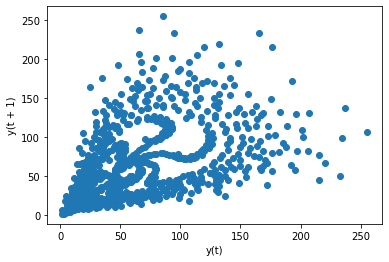

In [340]:
from pandas.plotting import lag_plot
lag_plot(series)

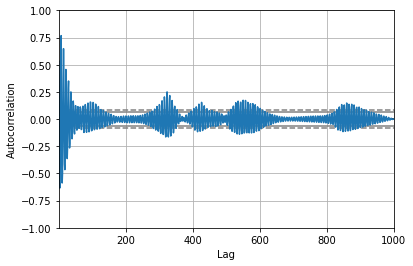

In [341]:
# The resulting plot shows lag along the x-axis and the correlation on the y-axis. 
# Dotted lines are provided that indicate any correlation values above those lines are statistically significant (meaningful).

# Correlation with lag across the x-axis (lag is the past observations, lag1 is the previous, lag2 is two back and so on.....)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



mat = loadmat(dataset_path + 'Xtrain.mat')
mdata = mat['Xtrain']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mdata)
data_scale = scaler.transform(mdata)
number_lag  = 80
data = series_to_supervised(data_scale, number_lag)

In [0]:
X = np.array(data[[col for col in data.columns if col != 'var1(t)']])
Y = np.array(data['var1(t)'])

In [609]:
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, Y, test_size=0.2, random_state=23)
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

#X_train.shape, X_test.shape, X_val.shape
print("Training instances   {}".format(X_train.shape[0]))
print("Validation instances {}".format(X_val.shape[0]))
print("Testing instances    {}".format(X_test.shape[0]))

Training instances   736
Validation instances 92
Testing instances    92


In [0]:
# Regression Example With Boston Dataset: Baseline
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
# define base model
def regression_model(input_size):
# create model
  model = Sequential()
  model.add(Dense(128, input_dim=input_size, kernel_initializer='normal', activation='relu'))
  # model.add(Dropout(0.2))
  model.add(Dense(64, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(32, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam',)
  return model

In [611]:
model = regression_model(X_train.shape[1])
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), batch_size=16)

Train on 736 samples, validate on 92 samples
Epoch 1/1000
736/736 [==============================] - 0s 318us/step - loss: 0.0376 - val_loss: 0.0225
Epoch 2/1000
736/736 [==============================] - 0s 170us/step - loss: 0.0153 - val_loss: 0.0137
Epoch 3/1000
736/736 [==============================] - 0s 175us/step - loss: 0.0094 - val_loss: 0.0121
Epoch 4/1000
736/736 [==============================] - 0s 177us/step - loss: 0.0068 - val_loss: 0.0144
Epoch 5/1000
736/736 [==============================] - 0s 203us/step - loss: 0.0058 - val_loss: 0.0106
Epoch 6/1000
736/736 [==============================] - 0s 171us/step - loss: 0.0046 - val_loss: 0.0116
Epoch 7/1000
736/736 [==============================] - 0s 184us/step - loss: 0.0037 - val_loss: 0.0099
Epoch 8/1000
736/736 [==============================] - 0s 174us/step - loss: 0.0035 - val_loss: 0.0108
Epoch 9/1000
736/736 [==============================] - 0s 172us/step - loss: 0.0028 - val_loss: 0.0113
Epoch 10/1000
736/7

dict_keys(['val_loss', 'loss'])


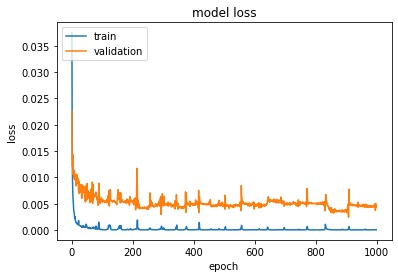

In [613]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [614]:
from sklearn.metrics import mean_squared_error
import numpy as np
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
print("MSE SCALED DATA", mean_squared_error(y_test, y_pred))
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)  
print("MSE NORMAL DATA",mean_squared_error(y_test_inverse, y_pred_inverse))

MSE SCALED DATA 0.000900829917499179
MSE NORMAL DATA 57.66124394622872


#comparison with last 200 predictions training set

In [0]:
real_value = data_scale[-200:].reshape(1,200)
real_value = (scaler.inverse_transform(real_value)).reshape(200,1)
offset = 200 + number_lag
series = data_scale[- offset:-200].reshape(1,number_lag)
prediction = []
for i in range(200):
  y_pred = model.predict(series.reshape(1,number_lag))
  prediction.append(scaler.inverse_transform(y_pred))
  series = np.delete(series, 0)
  series = np.append(series, y_pred)
prediction = np.array(prediction).reshape(200,1)

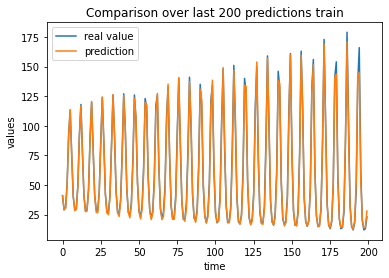

In [616]:
time = np.arange(200)
plt.plot(time, real_value, label='real value')
plt.plot(time, prediction, label='prediction')
plt.title("Comparison over last 200 predictions train")
plt.xlabel('time')
plt.ylabel('values')
plt.legend()
plt.show()

## Comparison with test data

In [0]:
series = data_scale[-number_lag:].reshape(1,number_lag)
prediction = []
for i in range(200):
  y_pred = model.predict(series.reshape(1,number_lag))
  prediction.append(scaler.inverse_transform(y_pred))
  series=np.delete(series, 0)
  series= np.append(series, y_pred)
prediction = np.array(prediction).reshape(200,1)

In [0]:
mat = loadmat(dataset_path + 'Xtest.mat')
real_value = mat['Xtest']

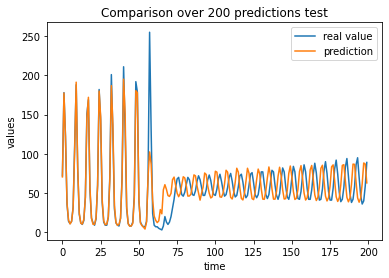

In [619]:
time = np.arange(200)
plt.plot(time, real_value, label='real value')
plt.plot(time, prediction, label='prediction')
plt.title("Comparison over 200 predictions test")
plt.xlabel('time')
plt.ylabel('values')
plt.legend()
plt.show()